In [1]:

#Importing important libraires
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
!pip install bert-for-tf2
from bert import bert_tokenization
#!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
#import tokenization


#Gpu usage
tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30515 sha256=0339dd81158d7a2cf52657058c79ac043e7dae53aad19724e845b72d378b74e0
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19457 sha256=3a1752deca87adaf6d23d4ac12ef19ae58c9a8836ae2f3cc424d44e067501163
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7892 sha256=45a6c757116ab1d721149088664312ac3a525501b38f95b7c73c8952d98eac1d
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

In [4]:
#setting a seed: The answer to the life
SEED = 42
def seed_everything(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed) 
    
seed_everything(SEED) 

Reading in the data using pandas. We will tokenize the text later in the notebook.

In [5]:
#reading input data with pandas, this is for kaggle, you can change it for your local folders
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

#visualizing some of the tweets
for i, val in enumerate(train.iloc[:2]["text"].to_list()):
    print("Tweet {}: {}".format(i+1, val))

Tweet 1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tweet 2: Forest fire near La Ronge Sask. Canada


In [6]:
#To see how many labels are positive or negative
print(sum(train.target==1))
print(sum(train.target==0))

3271
4342


In [7]:
#To see what we do have in the pandas file
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [9]:
#You can use the following code to drop if you have duplicates

#train = train.drop_duplicates(subset=['text'], keep='first')
#train.info()


In [10]:

# The following functions are defined for preprocessing. 


def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)

In [11]:
import re
import string

In [12]:
#We will create new series from train["text"]

train['text_clean'] = train['text'].apply(lambda x: x.lower())
train['text_clean'] = train['text_clean'].apply(lambda x: remove_URL(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_punct(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_non_ascii(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_html(x))


train.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [13]:
#Same for test data

test['text_clean'] = test['text'].apply(lambda x: x.lower())
test['text_clean'] = test['text_clean'].apply(lambda x: remove_URL(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_punct(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_non_ascii(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_emoji(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_html(x))


test.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [14]:
test['text_clean']

0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4           typhoon soudelor kills 28 in china and taiwan
                              ...                        
3258    earthquake safety los angeles  safety fastener...
3259    storm in ri worse than last hurricane my citya...
3260                    green line derailment in chicago 
3261            meg issues hazardous weather outlook hwo 
3262    cityofcalgary has activated its municipal emer...
Name: text_clean, Length: 3263, dtype: object

In [15]:
#What is the max length of any text? This will be important for tokenization

print(min(train["text"].apply(len)))
max(train["text"].apply(len))


7


157

## <center>bert_encode function</center>


### tokenizer
We are using the [Tensorflow Research's BERT tokenization method](https://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.py). This tokenization method can be thought of as three steps.

- Text Normalization
    - The first part of the tokenizer converts the text to lowercase (given that we are using the uncased version of roBERTa), converts whitespace to spaces, and strips out accent markers.
    ```
    "Alex Pättason's, "  -> "alex pattason's,"
    ```
    <br></br>
- Punctuation splitting
    - This next step adds spaces on each side of all "punctuation". Note that this includes any non-letter/number/space ASCII characters (ie including \$, \@). See more of this in the Docs. 
    ```
    "Alex Pättason's, "  -> "alex pattason ' s ,"
    ```
    <br></br>
- WordPiece tokenization
    - This step applies what is called whitespace tokenization to the output of the process above, and apply's WordPiece tokenization to each word separately. See the example below.
    ```
    "Alex Pättason's, "  -> "alex pat ##ta ##son ' s ,"
    ```
   
### tags
The next part of the function reduces the length of the text by the max_length that we have specified and adds [CLS] and [SEP] tags to the end of the array. The [CLS] tag is short for classification and indicates the start of the sentence. Similarly, the [SEP] tag indicates the end of the sentence.

### convert_tokens_to_ids + pad_masks

We then use the tokenizer method to replace the string representation of words with integers. We also create the input mask (AKA pad_masks), and the segment id's. Note that we are not fulfilling the segment_ids full benefits below as we are only passing an array of zeros. More on the tokens, pad_masks, and segment_ids further in the notebook.

In [16]:
#This is encoder for Bert. You can choose max-length of text for this.

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## <center>build_model function</center>

The first three components of the function are basically preprocessing plain text inputs into the input format expected by the roBERTa model.

### input_word_ids
- Basically maps each word to its token id. There can be multiple different values that correspond with the same word. For example, "smell" could be encoded both as 883 and 789.
<br></br>
```
text = "I love this notebook. It is Great."
input_word_ids = [10, 235, 123, 938, 184, 301, 567]
```

### the input_mask
- Shows where the sentence begins, and where it ends using an array. All input tokens that are not padding are given a value of 1, and all values that are padding are given 0. If the sentence exceeds that max_length, then the entire vector will be of 1's.
<br></br>
```
text = "I love this notebook. It is Great."
input_mask = [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
```

### segment_ids
- This component is still a little vague for me, but from my understanding, it is recognizing segments of the text. The start of each segment has a 1 in the array, and other components and padding all have a zero. I am unsure as to whether this corresponds to the end of sentences or paragraphs, but if you can explain this better please do so in the comments below!
<br></br>
```
text = "I love this notebook. It is Great."
segment_ids = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
```

In [18]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    #could be pooled_output, sequence_output yet sequence output provides for each input token (in context)
    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    #new_output = Dense(256, activation='relu')(clf_output)
    #c_output = Dense(256, activation='relu')(new_output)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    #specifying optimizer
    model.compile(Adam(learning_rate=6*10**(-6)), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Build Model 

The first cell below is basically loading in the version of the BERTa model that we want to use. We are using a Large uncased model. The most simple way to use a BERTa model and modify it to a specific use case is to set it as a KerasLayer.

Note there are many different variations of BERT models that you can look through here --> [TFhub Bert](https://tfhub.dev/google/collections/bert/1)


In [19]:
#load uncased bert model
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)


In the next cell, we are setting up the tokenizer that will be used to preprocess our input data to what BERT understands. We have to specify a vocab file so that the tokenizer knows what number to encode each word as then we have to specify whether we want uncased or cased text. We will use the same vocab_file that the pre-trained model was trained on (Google's SentencePiece in this case) and we will also use the same case that the model was built for (uncased).

Finally, once we have these two variables, we create the tokenizer and tokenize the training and testing data using the bert_encode function that we created above. 

In [21]:
max_len = 157
#vocab file from pre-trained BERT for tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#returns true/false depending on if we selected cased/uncased bert layer
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#Create the tokenizer
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

#tokenizing the training and testing data
train_input = bert_encode(train.text.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.text.values, tokenizer, max_len=max_len)
train_labels = train.target.values

Having a look at the model summary. We can see the three input layers that we created followed by the roBERTa model which is in the keras_layer. We have the final dense layer which predicts the sentiment of the tweet on a scale of 0-1. 

In [22]:
model = build_model(bert_layer, max_len=max_len)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 157)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 157)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 157)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 157, 1024)]               'input_mask[0][0]',         

In [23]:
#https://alexadam.ca/ml/2018/08/03/early-stopping.html. This early stopping is important for not to overfit.
import keras.backend as K
from keras.callbacks import Callback
import numpy as np

class FixedEarlyStopping(Callback):
    """Stop training when a monitored quantity has stopped improving.
    # Arguments
        monitors: quantities to be monitored.
        min_deltas: minimum change in the monitored quantities
            to qualify as an improvement, i.e. an absolute
            change of less than min_delta, will count as no
            improvement.
        patience: number of epochs with no improvement
            after which training will be stopped.
        verbose: verbosity mode.
        modes: list of {auto, min, max}. In `min` mode,
            training will stop when the quantities
            monitored has stopped decreasing; in `max`
            mode it will stop when the quantity
            monitored has stopped increasing; in `auto`
            mode, the direction is automatically inferred
            from the name of the monitored quantity.
        baselines: Baseline values for the monitored quantities to reach.
            Training will stop if the model doesn't show improvement
            for at least one of the baselines.
    """

    def __init__(self,
                 monitors=['val_loss'],
                 min_deltas=[0],
                 patience=0,
                 verbose=0,
                 modes=['auto'],
                 baselines=[None]):
        super(FixedEarlyStopping, self).__init__()

        self.monitors = monitors
        self.baselines = baselines
        self.patience = patience
        self.verbose = verbose
        self.min_deltas = min_deltas
        self.wait = 0
        self.stopped_epoch = 0
        self.monitor_ops = []
        
        
        for i, mode in enumerate(modes):
            if mode not in ['auto', 'min', 'max']:
                warnings.warn('EarlyStopping mode %s is unknown, '
                              'fallback to auto mode.' % mode,
                              RuntimeWarning)
                modes[i] = 'auto'

        for i, mode in enumerate(modes):
            if mode == 'min':
                self.monitor_ops.append(np.less)
            elif mode == 'max':
                self.monitor_ops.append(np.greater)
            else:
                if 'acc' in self.monitors[i]:
                    self.monitor_ops.append(np.greater)
                else:
                    self.monitor_ops.append(np.less)

        for i, monitor_op in enumerate(self.monitor_ops):
            if monitor_op == np.greater:
                self.min_deltas[i] *= 1
            else:
                self.min_deltas[i] *= -1

    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.waits = []
        self.stopped_epoch = 0
        self.bests = []
        
        for i, baseline in enumerate(self.baselines):
            if baseline is not None:
                self.bests.append(baseline)
            else:
                self.bests.append(np.Inf if self.monitor_ops[i] == np.less else -np.Inf)
                
            self.waits.append(0)

    def on_epoch_end(self, epoch, logs=None):
        reset_all_waits = False
        for i, monitor in enumerate(self.monitors):
            current = logs.get(monitor)

            if current is None:
                warnings.warn(
                    'Early stopping conditioned on metric `%s` '
                    'which is not available. Available metrics are: %s' %
                    (monitor, ','.join(list(logs.keys()))), RuntimeWarning
                )
                return
            
            if self.monitor_ops[i](current - self.min_deltas[i], self.bests[i]):
                self.bests[i] = current
                self.waits[i] = 0
                reset_all_waits = True
            else:
                self.waits[i] += 1
        
        if reset_all_waits:
            for i in range(len(self.waits)):
                self.waits[i] = 0
            
            return
        
        num_sat = 0
        for wait in self.waits:
            if wait >= self.patience:
                num_sat += 1
                
        if num_sat == len(self.waits):
            self.stopped_epoch = epoch
            self.model.stop_training = True
        
        print(self.waits)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

## Training Model

The next cell is a simple way of training the model using Keras. We have included the built-in ModelCheckpoint callback to only save the model that has the highest validation accuracy. This ensures we are only saving the best models. 


We could decrease the randomness of the split by doing some sort of a stratified split, or cross-validation, but this will do for now.

In [24]:
#checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, patience=3)
checkpoint = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
#FixedEarlyStopping()

#You can change hyperparameters with Grid-Search or Bayesian Search (I never used) 

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=100,
    callbacks=[checkpoint],
    batch_size=10,
    shuffle=True
)

# # max_len with 1: 200
# # Epoch 1/3
# 381/381 [==============================] - 507s 1s/step - loss: 0.4273 - accuracy: 0.8158 - val_loss: 0.3778 - val_accuracy: 0.8431
# Epoch 2/3
# 381/381 [==============================] - 472s 1s/step - loss: 0.2881 - accuracy: 0.8834 - val_loss: 0.3937 - val_accuracy: 0.8332

Epoch 1/100
609/609 [==============================] - 498s 671ms/step - loss: 0.4278 - accuracy: 0.8169 - val_loss: 0.3764 - val_accuracy: 0.8490
Epoch 2/100
609/609 [==============================] - 406s 666ms/step - loss: 0.3247 - accuracy: 0.8677 - val_loss: 0.4024 - val_accuracy: 0.8365
Epoch 3/100
609/609 [==============================] - 405s 666ms/step - loss: 0.2614 - accuracy: 0.9000 - val_loss: 0.4725 - val_accuracy: 0.8273


In [25]:
import matplotlib.pyplot as plt

## Make Prediction

Using the model to make predictions on the testing set. We round the prediction to 1 or 0. 1 is a disaster tweet, and 0 is a regular tweet.

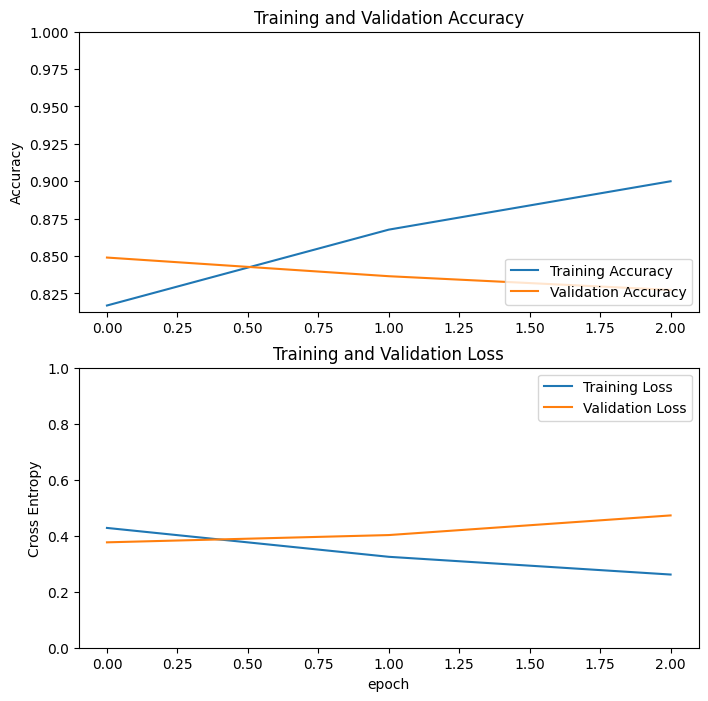

In [26]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
# If you don't overfit or underfit, you can submit
test_pred = model.predict(test_input)

submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 61s 594ms/step
